# Comparison

Between the new MC2020 and the DBD samples of ILD for $\sqrt{s}=250~$GeV.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats.distributions as dist
import uproot

higgs_name = {3: "H→ss", 4: "H→cc", 5: "H→bb", 13: "H→μμ", 15: "H→ττ",
    20: "H→Zγ", 21: "H→gluons", 22: "H→γγ", 23: "H→ZZ*", 24: "H→WW"}
number2decay = lambda number: higgs_name[number]

this_project = Path.home() / "ILD_vvH_DBD_vs_MC2020"  # This might be different depending on where you put the git repo.
data = this_project / "data"

kek_path = Path("home/ilc/kunath/vvH_DBD_vs_MC2020/data")
# If working on kek-cc, my rootfiles might still/already be available.
# if kek_path.exists(): data = Path("home/ilc/kunath/vvH_DBD_vs_MC2020/data")

fig_dir = this_project / "doc/fig"
# fig_dir = this_project / "compare" # To not overwrite the presentation figures while playing around.
fig_dir.mkdir(exist_ok=True)
dpi = 300
facecolor=None

In [2]:
new            = uproot.open(data / "new_with_overlay.root")["higgs"].pandas.df()
new_only_higgs = uproot.open(data / "new_only_higgs.root"  )["higgs"].pandas.df()
old            = uproot.open(data / "old_with_overlay.root")["higgs"].pandas.df()
old_only_higgs = uproot.open(data / "old_only_higgs.root"  )["higgs"].pandas.df()

## Overlay (non-Higgs parts)

In [3]:
# Overlay

new_overlay = (new - new_only_higgs)[[c for c in new.columns if c.startswith("n_")] + ["e_h"]]
old_overlay = (old - old_only_higgs)[[c for c in old.columns if c.startswith("n_")] + ["e_h"]]

new_overlay["energy"] = new_overlay["e_h"] 
new_overlay = new_overlay.drop(columns=["e_h", "n_isolated_leptons"])
old_overlay["energy"] = old_overlay["e_h"] 
old_overlay = old_overlay.drop(columns=["e_h", "n_isolated_leptons"])

pfo_types = dict(n_muons="#$\mu^\pm$", n_electrons="#$e^\pm$", n_gamma="#$\gamma~~$", 
                 n_charged_hadrons="#$h^\pm$", n_neutral_hadrons="#$h^0$")
assert all(new_overlay["n_pfos"] == sum(new_overlay[c] for c in pfo_types))
assert all(old_overlay["n_pfos"] == sum(old_overlay[c] for c in pfo_types))

overlay_pairs = [
    (old_overlay, new_overlay),
    (old_overlay[old_overlay.n_pfos > 0], new_overlay[new_overlay.n_pfos > 0]),
]

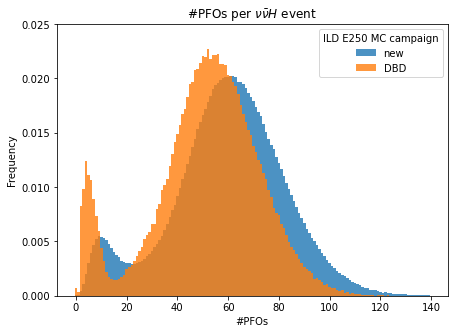

In [4]:
# Part 1: Only the "full" event.
fig_full_pfo, ax = plt.subplots(figsize=(7, 5))
bins = np.arange(-.5, 140, 1)#
kw = dict(ax=ax, density=True, bins=bins, alpha=.8)
new.n_pfos.plot.hist(label="new", color="C0", **kw)
old.n_pfos.plot.hist(label="DBD", color="C1", **kw)
ax.set_ylim((None, .025))
ax.set_xlabel("#PFOs")
ax.set_ylabel("Frequency")
ax.set_title("#PFOs per $\\nu\\bar{\\nu}H$ event")
ax.legend(title="ILD E250 MC campaign")
fig_full_pfo.savefig(fig_dir / "n_pfos_full_event.png",
    dpi=dpi, facecolor=facecolor)

In [5]:
# Part 2: Remove the overlay.
kw["histtype"] = "step"
kw["alpha"] = 1
kw["linewidth"] = 2
new_only_higgs.n_pfos.plot.hist(label="related to", color="C0", **kw)
old_only_higgs.n_pfos.plot.hist(label="MC Higgs", color="C1", **kw)
ax.legend(title="ILD E250 MC campaign")
fig_full_pfo

fig_full_pfo.savefig(fig_dir / "n_pfos_full_and_only_higgs.png",
    dpi=dpi, facecolor=facecolor)

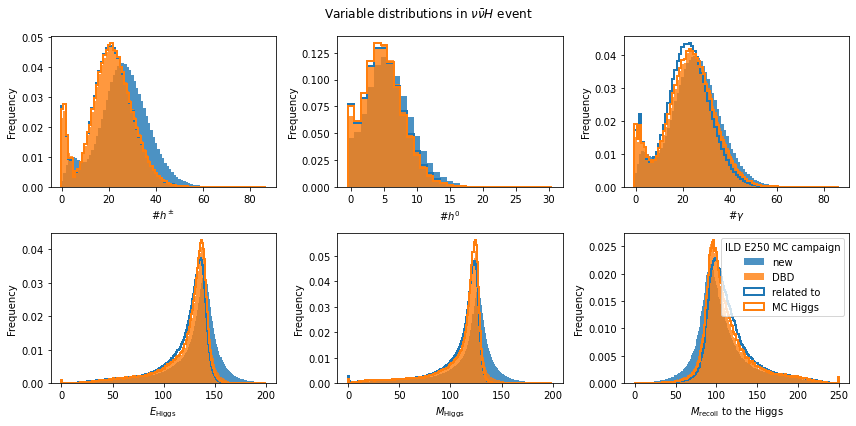

In [6]:
latex_name = dict(
    n_charged_hadrons="#$h^\pm$",
    e_h="$E_\mathrm{Higgs}$",
    n_neutral_hadrons="#$h^0$",
    m_h="$M_\mathrm{Higgs}$",
    n_gamma="#$\gamma$",
    m_h_recoil="$M_\mathrm{recoil}$ to the Higgs",
)
fig_many_w_wo_overlay, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# for i, var in enumerate(new.columns):
#     fig_many_w_wo_overlay, ax = plt.subplots(figsize=(7, 5))
for i, var in enumerate(latex_name):
    ax = axs[i%2][i//2]
    bins = np.arange(-.5, new[var].max() + 1, 1)
    if var in ["e_h", "m_h"]:
        bins = np.arange(-.5, 200, 1)
    if var == "cos_theta_miss":
        bins = np.linspace(-1, 1, 200)
    if var in ["h_invisible",         # Pretty much the same in both, since H→ZZ* stayed almost equal.
               "h_decay",             # Looked at below (own chapter). 
               "n_pfos",              # Already handled above.
               "n_isolated_leptons",  # Looked at below (own chapter). 
               "n_pfos_not_forward",  # Only abs(cos(theta)) < 0.95 PFOs. Does not seem useful.
               "n_muons",             # Small differences, e.g. in H→ss. But not that interesting overall.
               "n_electrons",         # Differences (especially with overlay), but no nice story with it.
               "cos_theta_miss",      # Seems ok. Maybe look again into H→ττ with more statistics (a slight cos(θ)² structure when including overlay).      
               ]:
        continue

    kw = dict(ax=ax, density=True, bins=bins, alpha=.8)
    new[var].plot.hist(label="new", color="C0", **kw)
    old[var].plot.hist(label="DBD", color="C1", **kw)
    ax.set_xlabel(latex_name[var] if var in latex_name else var)
    ax.set_ylabel("Frequency")

    kw["histtype"] = "step"
    kw["alpha"] = 1
    kw["linewidth"] = 2
    new_only_higgs[var].plot.hist(label="related to", color="C0", **kw)
    old_only_higgs[var].plot.hist(label="MC Higgs", color="C1", **kw)

ax.legend(title="ILD E250 MC campaign")
fig_many_w_wo_overlay.suptitle("Variable distributions in $\\nu\\bar{\\nu}H$ event")
fig_many_w_wo_overlay.tight_layout()
fig_many_w_wo_overlay.savefig(fig_dir / "many_variables_full_and_only_higgs.png",
    dpi=dpi, facecolor=facecolor)

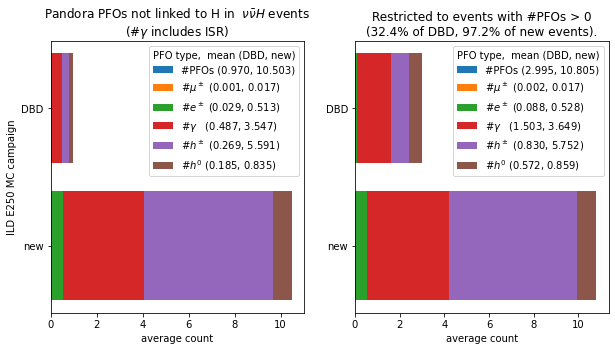

In [7]:
fig_pfo_means, axs = plt.subplots(ncols=2, figsize=(10, 5))
for i, dfs in enumerate(overlay_pairs):
    ax = axs[i]
    old_df, new_df = dfs
    old_left, new_left = 0, 0
    ax.barh([0, 1], [0, 0], label=f"#PFOs ({old_df.n_pfos.mean():.3f}, {new_df.n_pfos.mean():.3f})")
    for pfo_type in pfo_types:
        new_mean = new_df[pfo_type].mean()
        old_mean = old_df[pfo_type].mean()
        ax.barh([0, 1], 
               [new_mean, old_mean],
               left=[new_left, old_left],
               label=f"{pfo_types[pfo_type]} ({old_mean:.3f}, {new_mean:.3f})",
        )
        new_left += new_mean
        old_left += old_mean
    ax.set_xlabel("average count")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["new", "DBD"])
    ax.legend(title="PFO type,  mean (DBD, new)")

f_old = 100 * len(old_overlay[old_overlay.n_pfos > 0]) / len(old_overlay)
f_new = 100 * len(new_overlay[new_overlay.n_pfos > 0]) / len(new_overlay)
axs[1].set_title("\n".join(["Restricted to events with #PFOs > 0",
                           f"({f_old:.1f}% of DBD, {f_new:.1f}% of new events)."]))
axs[0].set_title("Pandora PFOs not linked to H in  $\\nu\\bar{\\nu}H$ events \n(#$\gamma$ includes ISR)")
axs[0].set_ylabel("ILD E250 MC campaign")
fig_pfo_means.savefig(fig_dir / "overlay_counts_per_group.png",
    dpi=dpi, facecolor=facecolor)

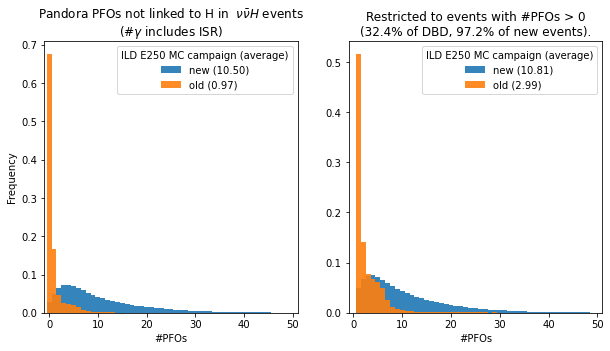

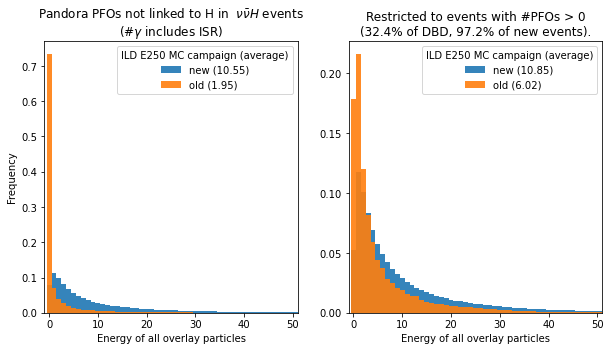

In [8]:
overlay_figs = {}

to_latex = dict(n_pfos="#PFOs", energy="Energy of all overlay particles")
for var in ["n_pfos", "energy"]:
# for var in new_overlay.columns:
    overlay_figs[var] = plt.figure(figsize=(10, 5))
    axs = []
    for i, dfs in enumerate(overlay_pairs):
        axs.append(overlay_figs[var].add_subplot(1, len(overlay_pairs), i + 1))
        ax = axs[i]
        old_df, new_df = dfs

        bins = np.arange(-.5, 1 + int(max(new_df[var].max(), old_df[var].max())))
        kw = dict(bins=bins, density=True, alpha=.9)
        ax.hist(new_df[var], label=f"new ({new_df[var].mean():.2f})", **kw)
        ax.hist(old_df[var], label=f"old ({old_df[var].mean():.2f})", **kw)
        ax.set_xlabel(to_latex[var] if var in to_latex else var)
        ax.set_xlim((-1, 51))
        ax.legend(title="ILD E250 MC campaign (average)")

    f_old = 100 * len(old_overlay[old_overlay.n_pfos > 0]) / len(old_overlay)
    f_new = 100 * len(new_overlay[new_overlay.n_pfos > 0]) / len(new_overlay)
    axs[1].set_title("\n".join(["Restricted to events with #PFOs > 0",
                            f"({f_old:.1f}% of DBD, {f_new:.1f}% of new events)."]))
    axs[0].set_title("Pandora PFOs not linked to H in  $\\nu\\bar{\\nu}H$ events \n(#$\gamma$ includes ISR)")
    axs[0].set_ylabel("Frequency")
    overlay_figs[var].savefig(fig_dir / f"overlay_{var}.png",
        dpi=dpi, facecolor=facecolor)

In [9]:
for var, fig in overlay_figs.items():
    for ax in fig.axes: 
        ax.set_xlim((None, None))
        ax.set_yscale("log")
    overlay_figs[var].savefig(fig_dir / f"overlay_{var}_log.png",
        dpi=dpi, facecolor=facecolor)

## Isolated Lepton tagging

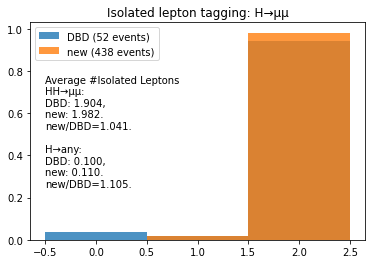

In [10]:
fig_isolep, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Isolated lepton tagging: H→μμ")
old[old.h_decay == 13].n_isolated_leptons.hist(ax=ax, bins=np.arange(-.5, 3), density=True, alpha=.8, label=f"DBD ({len(old[old.h_decay == 13])} events)")
new[new.h_decay == 13].n_isolated_leptons.hist(ax=ax, bins=np.arange(-.5, 3), density=True, alpha=.8, label=f"new ({len(new[new.h_decay == 13])} events)")
ax.grid(False)
ax.text(-.5, .25, "\n".join(["Average #Isolated Leptons",
    "HH→μμ:",
    f"DBD: {old[old.h_decay == 13].n_isolated_leptons.mean():.3f},",
    f"new: {new[new.h_decay == 13].n_isolated_leptons.mean():.3f}.",
    f"new/DBD={new[new.h_decay == 13].n_isolated_leptons.mean() / old[old.h_decay == 13].n_isolated_leptons.mean():.3f}.",
    "",
    "H→any:",
    f"DBD: {old.n_isolated_leptons.mean():.3f},",
    f"new: {new.n_isolated_leptons.mean():.3f}.",
    f"new/DBD={new.n_isolated_leptons.mean() / old.n_isolated_leptons.mean():.3f}.",
]))
ax.legend()
fig_isolep.savefig(fig_dir / "isolated_leptons.png",
    dpi=dpi, facecolor=facecolor)

## MC truth: Higgs decays

In [11]:
def binomialProportionMeanAndCL(total_h, pass_h, cl=0.683, a=1, b=1):
    """a,b: Parameters of the prior (Beta function B(a, b)).
    B(1, 1) is the uniform distribution U(0,1).
    Jeffreys prior: B(.5, .5)

    Expected value is NOT nSelected/nEvents.
    While that is the most probable value /mode,the expected value / mean is
    given by (nSelected+1.)/(nEvents+2.).

    From: https://arxiv.org/pdf/0908.0130.pdf
    Unused source: https://indico.cern.ch/event/66256/contributions/2071577/attachments/1017176/1447814/EfficiencyErrors.pdf
    """
    mean = (pass_h+1) / (total_h+2.)
    p_lower = dist.beta.ppf(  (1-cl)/2., pass_h+a, total_h-pass_h+b)
    p_upper = dist.beta.ppf(1-(1-cl)/2., pass_h+a, total_h-pass_h+b)
    err_lower = mean - p_lower
    err_upper = p_upper - mean
    return mean, err_lower, err_upper

In [12]:
branching_ratios = pd.DataFrame()
branching_ratios["new"] = new.groupby("h_decay")["n_pfos"].count()
branching_ratios["DBD"] = old.groupby("h_decay")["n_pfos"].count()

binom_old = lambda series: binomialProportionMeanAndCL(len(old), series)
old_brs = pd.DataFrame(zip(*branching_ratios["DBD"].apply(binom_old))).transpose()
old_brs.columns = ["μ", "σ_lower", "σ_upper"]
old_brs.index = branching_ratios["DBD"].index
old_brs = old_brs.rename(index=number2decay)

binom_new = lambda series: binomialProportionMeanAndCL(len(new), series)
new_brs = pd.DataFrame(zip(*branching_ratios["new"].apply(binom_new))).transpose()
new_brs.columns = ["μ", "σ_lower", "σ_upper"]
new_brs.index = branching_ratios["DBD"].index
new_brs = new_brs.rename(index=number2decay)

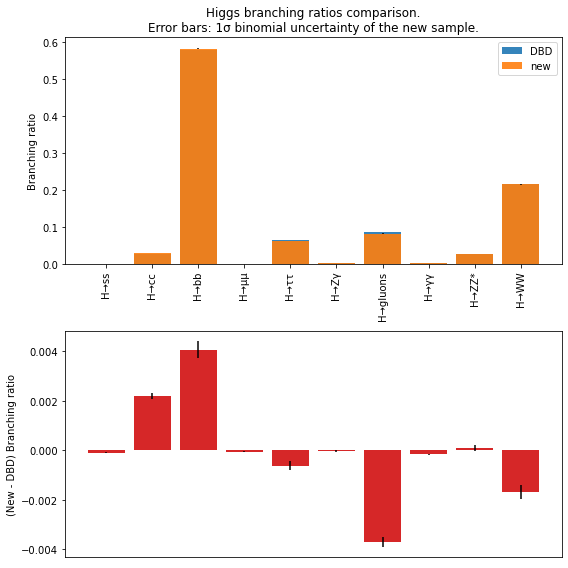

In [13]:
x = np.arange(len(old_brs))
def br_ax(ax):
    ax.set_xticks(x)
    ax.set_xticklabels(old_brs.index, rotation=90)
    ax.set_ylabel("Branching ratio")
    ax.bar(x, old_brs.μ, label="DBD", alpha=.9)
    ax.bar(x, new_brs.μ, yerr=(old_brs.σ_lower, old_brs.σ_upper), label="new", alpha=.9, color="C1")
    ax.legend()
    ax.set_title("Higgs branching ratios comparison.\nError bars: 1σ binomial uncertainty of the new sample.")


fig_brs, axs = plt.subplots(nrows=2, figsize=(8, 8))
axs[1].bar(x, new_brs.μ - old_brs.μ, yerr=(new_brs.σ_lower, new_brs.σ_upper), color="C3")
axs[1].set_xticks([])
axs[1].set_ylabel("(New - DBD) Branching ratio")
br_ax(axs[0])
fig_brs.tight_layout()
fig_brs.savefig(fig_dir / "branching_ratio_difference.png",
    dpi=dpi, facecolor=facecolor)

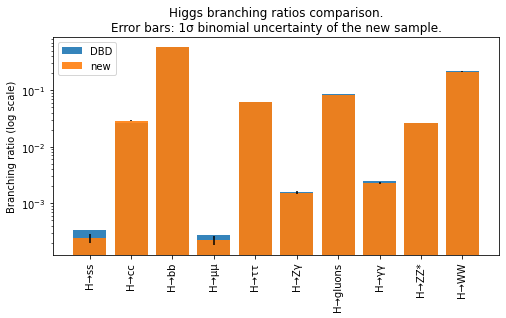

In [14]:
fig_brs_log, ax = plt.subplots(figsize=(8, 4))
br_ax(ax)
ax.set_ylabel("Branching ratio (log scale)")
ax.set_yscale("log")
fig_brs_log.savefig(fig_dir / "branching_ratio_difference_log.png",
    dpi=dpi, facecolor=facecolor)

In [15]:
print("BR(H→invisible)")
print(new.h_invisible.sum() / len(new))
print(old.h_invisible.sum() / len(old))

BR(H→invisible)
0.0010792554788351847
0.0010890997119821614


## The Higgs decay structure within a distribution - \#PFOs

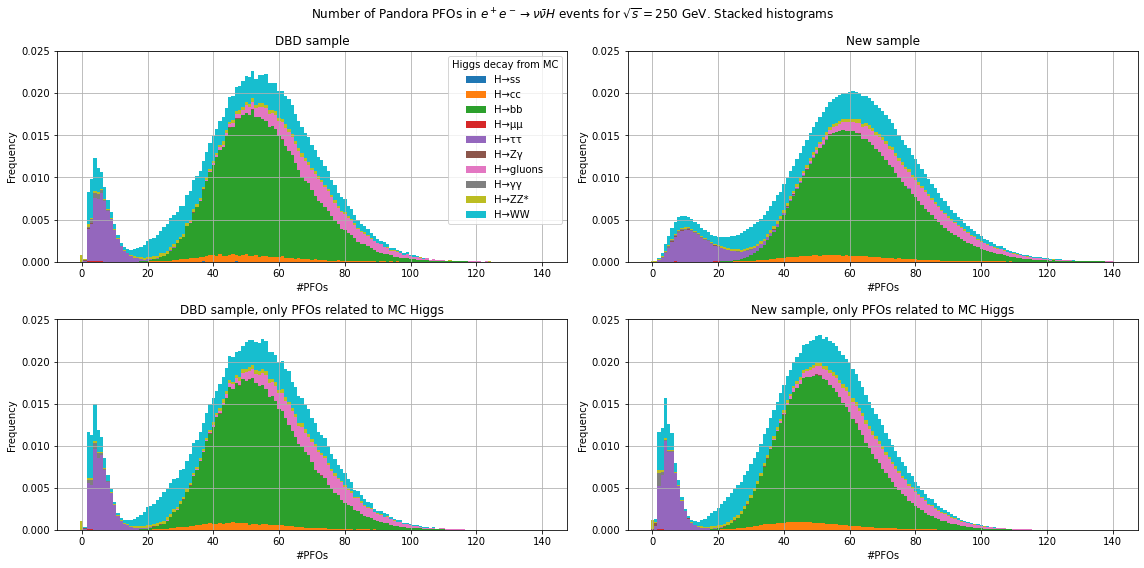

In [16]:
col = "n_pfos"

fig_pfos_per_decay, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))

bins = np.arange(-.5, 141, 1)
x = (bins[1:] + bins[:-1]) / 2.
w = (bins[1:] - bins[:-1]) 

axs[0][0].set_title("DBD sample")
axs[0][1].set_title("New sample")
axs[1][0].set_title("DBD sample, only PFOs related to MC Higgs")
axs[1][1].set_title("New sample, only PFOs related to MC Higgs")
for i, df in enumerate([old, old_only_higgs, new, new_only_higgs]):
    ax = axs[i%2][i//2]
    ax.set_ylabel("Frequency")
    ax.set_xlabel("#PFOs")
    y_bottom = np.zeros_like(x) 
    decay_dfs =  {k: table for k, table in df.groupby("h_decay")}
    for pdg in higgs_name.keys():
        single_decay_df = decay_dfs[pdg]
        y, _ = np.histogram(single_decay_df[col], bins=bins)
        y = y / len(df)
        ax.bar(x, y, w, y_bottom, label=number2decay(pdg))
        y_bottom += y
    ax.grid()
    ax.set_ylim((0, 0.025))  # This has to change for a different binning. 
axs[0][0].legend(title="Higgs decay from MC")
fig_pfos_per_decay.suptitle(("Number of Pandora PFOs in "
    r"$e^+e^-\rightarrow \nu\bar{\nu}H$ events for $\sqrt{s}=250~$GeV. Stacked histograms"))
fig_pfos_per_decay.tight_layout()
fig_pfos_per_decay.savefig(fig_dir / "decays_stacked_n_pfos.png",
    dpi=dpi, facecolor=facecolor)